In [1]:
from pathlib import Path
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid

In [2]:
DATA_PATH = Path().home() / "datasets"
dataset = Planetoid(root=DATA_PATH, name="Cora")

In [3]:
len(dataset), dataset.num_classes, dataset.num_features

(1, 7, 1433)

In [4]:
dataset.num_node_features, dataset.num_edge_features

(1433, 0)

In [5]:
data = dataset[0]
data.is_undirected()

True

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
        

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

cuda


In [8]:
model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [9]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print(f"Accuracy: {acc}")

Accuracy: 0.76


In [10]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

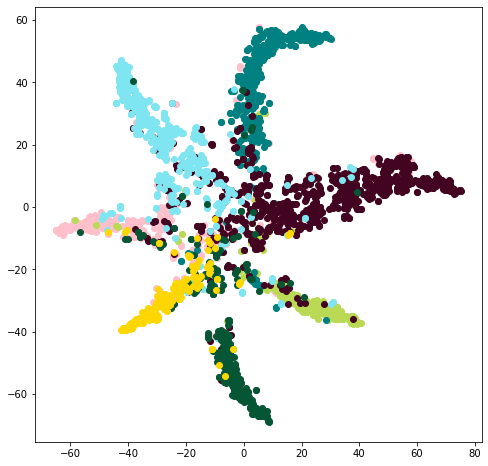

In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
with torch.no_grad():
    model.eval()
    z = model(data)
    z = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], color=colors[i])

    plt.show()